In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,MaxPooling2D,Flatten
from keras.models import Sequential
from keras.applications.xception import preprocess_input,Xception
from glob import glob
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from keras.optimizers import Adam

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
imgs = []
lbls = []

In [5]:
for i in glob('../input/chest-xray-covid19-pneumonia/Data/train/NORMAL/*'):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    imgs.append(img)
    lbls.append(0)

In [6]:
for i in glob('../input/chest-xray-covid19-pneumonia/Data/train/COVID19/*'):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    imgs.append(img)
    lbls.append(1)

In [7]:
for i in glob('../input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA/*'):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    imgs.append(img)
    lbls.append(2)


In [8]:
for i in glob('../input/chest-xray-covid19-pneumonia/Data/test/NORMAL/*'):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    imgs.append(img)
    lbls.append(0)

In [9]:
for i in glob('../input/chest-xray-covid19-pneumonia/Data/test/COVID19/*'):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    imgs.append(img)
    lbls.append(1)

In [10]:
for i in glob('../input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/*'):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    imgs.append(img)
    lbls.append(2)


In [11]:
lbls = to_categorical(lbls)

In [12]:
imgs = np.array(imgs)

In [13]:
trainx,testx,trainy,testy  = train_test_split(imgs,lbls,stratify = lbls,test_size = 0.15)

model = Sequential([
    Xception(include_top = False,input_shape = (128,128,3)),
    #MaxPooling2D(),
    Flatten(),
    Dense(256,activation = 'relu'),
    Dropout(0.3),
    Dense(3,activation='softmax')
])


model.compile('adam','categorical_crossentropy',['accuracy'])

hist = model.fit(trainx,trainy,validation_data=(testx,testy),epochs = 10)

preds = model.predict_classes(testx)

In [14]:
from sklearn.metrics import classification_report

print(classification_report(testy.argmax(1),preds))

In [15]:
!pip install Keras-Applications

     |████████████████████████████████| 50 kB 359 kB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [15]:
from keras.layers.advanced_activations import LeakyReLU

In [17]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K
from keras_applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.preprocessing import image


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.
    Arguments:
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    Returns:
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = LeakyReLU(name = name)(x)
    return x


def InceptionV3(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000):
    """Instantiates the Inception v3 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    Note that the default input image size for this model is 299x299.
    Arguments:
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 139.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    Returns:
        A Keras model instance.
    Raises:
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=128,
        data_format=K.image_data_format(),
        require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = Input(tensor=input_tensor, shape=input_shape)

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))
    xt = []
    if include_top:
        # Classification block
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        xt = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, [x, xt], name='inception_v3')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9a0d58056eeedaa3f26cb7ebd46da564')
        else:
            weights_path = get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='bcbd6486424b2319ff4ef7d526e38f63')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            convert_all_kernels_in_model(model)
    return model


def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x


def timeit(method):
    import time
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print ('%r %2.2f sec' % \
              (method.__name__, te-ts))
        return result

    return timed





In [18]:
net = InceptionV3(include_top=False,weights='imagenet',input_shape=(128,128,3))

87916544/87910968 [==============================] - 3s 0us/step


In [19]:
model = Sequential()
model.add(net)
model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(Dense(3,activation = 'softmax'))

In [20]:
model.compile(Adam(0.0001),'categorical_crossentropy',['accuracy'])

In [21]:
hist = model.fit(trainx,trainy,validation_data=(testx,testy),epochs = 15)

Epoch 1/15
171/171 [==============================] - 17s 98ms/step - loss: 0.2868 - accuracy: 0.9146 - val_loss: 1.5821 - val_accuracy: 0.8611
Epoch 2/15
171/171 [==============================] - 14s 83ms/step - loss: 0.1155 - accuracy: 0.9596 - val_loss: 1.5413 - val_accuracy: 0.9420
Epoch 3/15
171/171 [==============================] - 14s 83ms/step - loss: 0.0892 - accuracy: 0.9709 - val_loss: 0.2462 - val_accuracy: 0.9295
Epoch 4/15
171/171 [==============================] - 14s 83ms/step - loss: 0.0603 - accuracy: 0.9777 - val_loss: 0.1108 - val_accuracy: 0.9648
Epoch 5/15
171/171 [==============================] - 14s 84ms/step - loss: 0.0489 - accuracy: 0.9828 - val_loss: 0.1595 - val_accuracy: 0.9565
Epoch 6/15
171/171 [==============================] - 14s 83ms/step - loss: 0.0557 - accuracy: 0.9828 - val_loss: 0.1038 - val_accuracy: 0.9762
Epoch 7/15
171/171 [==============================] - 14s 83ms/step - loss: 0.1728 - accuracy: 0.9581 - val_loss: 0.2655 - val_accuracy:

In [22]:
preds = model.predict_classes(trainx)

In [23]:
print(classification_report(trainy.argmax(1),preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1345
           1       1.00      1.00      1.00       490
           2       1.00      0.98      0.99      3632

    accuracy                           0.98      5467
   macro avg       0.98      0.99      0.98      5467
weighted avg       0.98      0.98      0.98      5467



In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [25]:
mpl.rcParams.update({'font.size':18})

Text(0.5, 1.0, 'Training and Testing Loss')

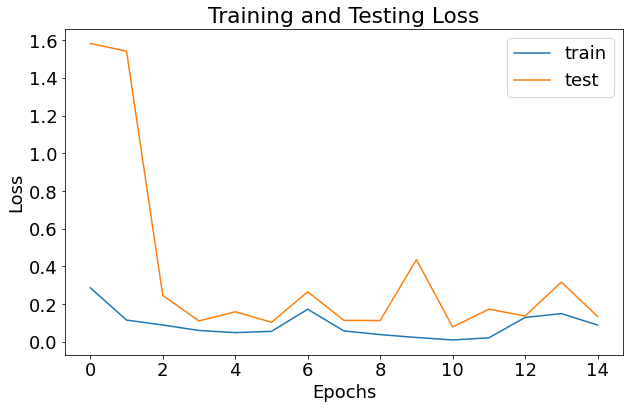

In [26]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')

Text(0.5, 1.0, 'Training and Testing Accuracy')

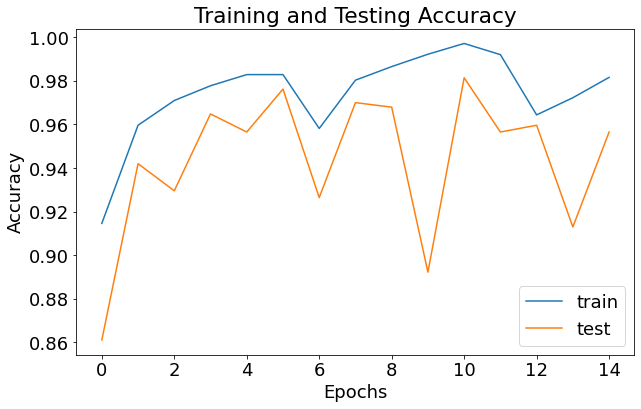

In [27]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')

In [28]:
print(classification_report(trainy.argmax(1),model.predict_classes(trainx)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1345
           1       1.00      1.00      1.00       490
           2       1.00      0.98      0.99      3632

    accuracy                           0.98      5467
   macro avg       0.98      0.99      0.98      5467
weighted avg       0.98      0.98      0.98      5467



In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [30]:
cm = confusion_matrix(trainy.argmax(1),model.predict_classes(trainx))

[Text(0.5, 0, 'Normal'), Text(1.5, 0, 'Covid-19'), Text(2.5, 0, 'Pneumonia')]

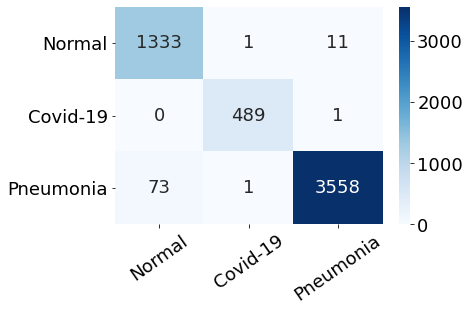

In [31]:
plot = sn.heatmap(cm,cmap = 'Blues',annot = True,yticklabels=['Normal','Covid-19','Pneumonia'],fmt = 'd')
plot.set_xticklabels(rotation = 35,labels = ['Normal','Covid-19','Pneumonia'])

In [32]:
cm = confusion_matrix(testy.argmax(1),model.predict_classes(testx))

[Text(0.5, 0, 'Normal'), Text(1.5, 0, 'Covid-19'), Text(2.5, 0, 'Pneumonia')]

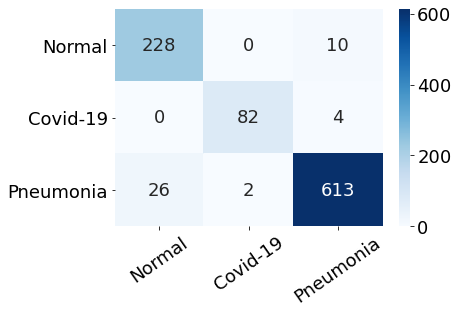

In [33]:
plot = sn.heatmap(cm,cmap = 'Blues',annot = True,yticklabels=['Normal','Covid-19','Pneumonia'],fmt = 'd')
plot.set_xticklabels(rotation = 35,labels = ['Normal','Covid-19','Pneumonia'])

In [16]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.preprocessing import image

from keras.models import Model
from keras import layers
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras import backend as K
from keras_applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape


TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'


def Xception(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the Xception architecture.
    Optionally loads weights pre-trained
    on ImageNet. This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    data format `(width, height, channels)`.
    You should set `image_data_format="channels_last"` in your Keras config
    located at ~/.keras/keras.json.
    Note that the default input image size for this model is 299x299.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)`.
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 71.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if K.backend() != 'tensorflow':
        raise RuntimeError('The Xception model is only available with '
                           'the TensorFlow backend.')
    if K.image_data_format() != 'channels_last':
        warnings.warn('The Xception model is only available for the '
                      'input data format "channels_last" '
                      '(width, height, channels). '
                      'However your settings specify the default '
                      'data format "channels_first" (channels, width, height). '
                      'You should set `image_data_format="channels_last"` in your Keras '
                      'config located at ~/.keras/keras.json. '
                      'The model being returned right now will expect inputs '
                      'to follow the "channels_last" data format.')
        K.set_image_data_format('channels_last')
        old_data_format = 'channels_first'
    else:
        old_data_format = None

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=299,
                                      min_size=71,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = LeakyReLU(name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = LeakyReLU(name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = LeakyReLU(name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = LeakyReLU(name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = LeakyReLU(name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = LeakyReLU(name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = LeakyReLU(name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = LeakyReLU(name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = LeakyReLU(name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = LeakyReLU(name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = LeakyReLU(name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = LeakyReLU(name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = LeakyReLU(name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = LeakyReLU(name='block14_sepconv2_act')(x)

    if include_top:
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='xception')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('xception_weights_tf_dim_ordering_tf_kernels.h5',
                                    TF_WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('xception_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    TF_WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)

    if old_data_format:
        K.set_image_data_format(old_data_format)
    return model


def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [17]:
net = Xception(weights = 'imagenet',include_top=False,input_shape=(128,128,3))

In [18]:
model = Sequential()
model.add(net)
model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(Dense(3,activation = 'softmax'))
model.compile(Adam(0.0001),'categorical_crossentropy',['accuracy'])
hist = model.fit(trainx,trainy,validation_data=(testx,testy),epochs = 15)

Epoch 1/15
171/171 [==============================] - 25s 146ms/step - loss: 0.4857 - accuracy: 0.8753 - val_loss: 5.6334 - val_accuracy: 0.7813
Epoch 2/15
171/171 [==============================] - 23s 135ms/step - loss: 0.1487 - accuracy: 0.9513 - val_loss: 0.1263 - val_accuracy: 0.9627
Epoch 3/15
171/171 [==============================] - 23s 136ms/step - loss: 0.1251 - accuracy: 0.9579 - val_loss: 0.1254 - val_accuracy: 0.9596
Epoch 4/15
171/171 [==============================] - 23s 135ms/step - loss: 0.0858 - accuracy: 0.9709 - val_loss: 0.0662 - val_accuracy: 0.9762
Epoch 5/15
171/171 [==============================] - 23s 135ms/step - loss: 0.0622 - accuracy: 0.9791 - val_loss: 0.0927 - val_accuracy: 0.9668
Epoch 6/15
171/171 [==============================] - 23s 137ms/step - loss: 0.0842 - accuracy: 0.9759 - val_loss: 0.1122 - val_accuracy: 0.9710
Epoch 7/15
171/171 [==============================] - 23s 135ms/step - loss: 0.0796 - accuracy: 0.9768 - val_loss: 0.2489 - val_ac

In [19]:
preds = model.predict_classes(trainx)

In [20]:
print(classification_report(trainy.argmax(1),preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1345
           1       1.00      0.99      1.00       490
           2       1.00      0.98      0.99      3632

    accuracy                           0.99      5467
   macro avg       0.99      0.99      0.99      5467
weighted avg       0.99      0.99      0.99      5467



In [21]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')

NameError: name 'plt' is not defined

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')

In [ ]:
cm = confusion_matrix(testy.argmax(1),model.predict_classes(testx))

In [ ]:
plot = sn.heatmap(cm,cmap = 'Blues',annot = True,yticklabels=['Normal','Covid-19','Pneumonia'],fmt = 'd')
plot.set_xticklabels(rotation = 35,labels = ['Normal','Covid-19','Pneumonia'])

In [18]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
from keras.layers.advanced_activations import LeakyReLU
import warnings

from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.core import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from keras.layers import Input
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape
import keras.backend as K

CIFAR_TH_WEIGHTS_PATH = ''
CIFAR_TF_WEIGHTS_PATH = ''
CIFAR_TH_WEIGHTS_PATH_NO_TOP = ''
CIFAR_TF_WEIGHTS_PATH_NO_TOP = ''

IMAGENET_TH_WEIGHTS_PATH = ''
IMAGENET_TF_WEIGHTS_PATH = ''
IMAGENET_TH_WEIGHTS_PATH_NO_TOP = ''
IMAGENET_TF_WEIGHTS_PATH_NO_TOP = ''


def ResNext(input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,
            include_top=True, weights=None, input_tensor=None,
            pooling=None, classes=10):
    """Instantiate the ResNeXt architecture. Note that ,
        when using TensorFlow for best performance you should set
        `image_data_format="channels_last"` in your Keras config
        at ~/.keras/keras.json.
        The model are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            depth: number or layers in the ResNeXt model. Can be an
                integer or a list of integers.
            cardinality: the size of the set of transformations
            width: multiplier to the ResNeXt width (number of filters)
            weight_decay: weight decay (l2 norm)
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: `None` (random initialization)
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(32, 32, 3)` (with `tf` dim ordering)
                or `(3, 32, 32)` (with `th` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            pooling: Optional pooling mode for feature extraction
                when `include_top` is `False`.
                - `None` means that the output of the model will be
                    the 4D tensor output of the
                    last convolutional layer.
                - `avg` means that global average pooling
                    will be applied to the output of the
                    last convolutional layer, and thus
                    the output of the model will be a 2D tensor.
                - `max` means that global max pooling will
                    be applied.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if weights not in {'cifar10', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    if weights == 'cifar10' and include_top and classes != 10:
        raise ValueError('If using `weights` as CIFAR 10 with `include_top`'
                         ' as true, `classes` should be 10')

    if type(depth) == int:
        if (depth - 2) % 9 != 0:
            raise ValueError('Depth of the network must be such that (depth - 2)'
                             'should be divisible by 9.')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_res_next(classes, img_input, include_top, depth, cardinality, width,
                          weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    # load weights
    if weights == 'cifar10':
        if (depth == 29) and (cardinality == 8) and (width == 64):
            # Default parameters match. Weights for this model exist:

            if K.image_data_format() == 'channels_first':
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels.h5',
                                            CIFAR_TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels_no_top.h5',
                                            CIFAR_TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('You are using the TensorFlow backend, yet you '
                                  'are using the Theano '
                                  'image dimension ordering convention '
                                  '(`image_dim_ordering="th"`). '
                                  'For best performance, set '
                                  '`image_dim_ordering="tf"` in '
                                  'your Keras config '
                                  'at ~/.keras/keras.json.')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels.h5',
                                            CIFAR_TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels_no_top.h5',
                                            CIFAR_TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


def ResNextImageNet(input_shape=None, depth=[3, 4, 6, 3], cardinality=32, width=4, weight_decay=5e-4,
                    include_top=True, weights=None, input_tensor=None,
                    pooling=None, classes=1000):
    """ Instantiate the ResNeXt architecture for the ImageNet dataset. Note that ,
        when using TensorFlow for best performance you should set
        `image_data_format="channels_last"` in your Keras config
        at ~/.keras/keras.json.
        The model are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            depth: number or layers in the each block, defined as a list.
                ResNeXt-50 can be defined as [3, 4, 6, 3].
                ResNeXt-101 can be defined as [3, 4, 23, 3].
                Defaults is ResNeXt-50.
            cardinality: the size of the set of transformations
            width: multiplier to the ResNeXt width (number of filters)
            weight_decay: weight decay (l2 norm)
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: `None` (random initialization) or `imagenet` (trained
                on ImageNet)
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(224, 224, 3)` (with `tf` dim ordering)
                or `(3, 224, 224)` (with `th` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            pooling: Optional pooling mode for feature extraction
                when `include_top` is `False`.
                - `None` means that the output of the model will be
                    the 4D tensor output of the
                    last convolutional layer.
                - `avg` means that global average pooling
                    will be applied to the output of the
                    last convolutional layer, and thus
                    the output of the model will be a 2D tensor.
                - `max` means that global max pooling will
                    be applied.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if type(depth) == int and (depth - 2) % 9 != 0:
        raise ValueError('Depth of the network must be such that (depth - 2)'
                         'should be divisible by 9.')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=112,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_res_next_imagenet(classes, img_input, include_top, depth, cardinality, width,
                                   weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    # load weights
    if weights == 'imagenet':
        if (depth == [3, 4, 6, 3]) and (cardinality == 32) and (width == 4):
            # Default parameters match. Weights for this model exist:

            if K.image_data_format() == 'channels_first':
                if include_top:
                    weights_path = get_file('resnext_imagenet_32_4_th_dim_ordering_th_kernels.h5',
                                            IMAGENET_TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_imagenet_32_4_th_dim_ordering_th_kernels_no_top.h5',
                                            IMAGENET_TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('You are using the TensorFlow backend, yet you '
                                  'are using the Theano '
                                  'image dimension ordering convention '
                                  '(`image_dim_ordering="th"`). '
                                  'For best performance, set '
                                  '`image_dim_ordering="tf"` in '
                                  'your Keras config '
                                  'at ~/.keras/keras.json.')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('resnext_imagenet_32_4_tf_dim_ordering_tf_kernels.h5',
                                            IMAGENET_TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_imagenet_32_4_tf_dim_ordering_tf_kernels_no_top.h5',
                                            IMAGENET_TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


def __initial_conv_block(input, weight_decay=5e-4):
    ''' Adds an initial convolution block, with batch normalization and relu activation
    Args:
        input: input tensor
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

    return x


def __initial_conv_block_imagenet(input, weight_decay=5e-4):
    ''' Adds an initial conv block, with batch norm and relu for the inception resnext
    Args:
        input: input tensor
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    return x


def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):
    ''' Adds a grouped convolution block. It is an equivalent block from the paper
    Args:
        input: input tensor
        grouped_channels: grouped number of filters
        cardinality: cardinality factor describing the number of groups
        strides: performs strided convolution for downscaling if > 1
        weight_decay: weight decay term
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    group_list = []

    if cardinality == 1:
        # with cardinality 1, it is a standard convolution
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        x = BatchNormalization(axis=channel_axis)(x)
        x = LeakyReLU()(x)
        return x

    for c in range(cardinality):
        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
        if K.image_data_format() == 'channels_last' else
        lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

        group_list.append(x)

    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = LeakyReLU()(x)

    return x


def __bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    ''' Adds a bottleneck block
    Args:
        input: input tensor
        filters: number of output filters
        cardinality: cardinality factor described number of
            grouped convolutions
        strides: performs strided convolution for downsampling if > 1
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
    init = input

    grouped_channels = int(filters / cardinality)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init._keras_shape[1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)
    else:
        if init.shape[-1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)

    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    x = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=channel_axis)(x)

    x = add([init, x])
    x = LeakyReLU()(x)

    return x


def __create_res_next(nb_classes, img_input, include_top, depth=29, cardinality=8, width=4,
                      weight_decay=5e-4, pooling=None):
    ''' Creates a ResNeXt model with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input tensor or layer
        include_top: Flag to include the last dense layer
        depth: Depth of the network. Can be an positive integer or a list
               Compute N = (n - 2) / 9.
               For a depth of 56, n = 56, N = (56 - 2) / 9 = 6
               For a depth of 101, n = 101, N = (101 - 2) / 9 = 11
        cardinality: the size of the set of transformations.
               Increasing cardinality improves classification accuracy,
        width: Width of the network.
        weight_decay: weight_decay (l2 norm)
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
    Returns: a Keras Model
    '''

    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  # double the size of the filters

    x = __initial_conv_block(img_input, weight_decay)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x


def __create_res_next_imagenet(nb_classes, img_input, include_top, depth, cardinality=32, width=4,
                               weight_decay=5e-4, pooling=None):
    ''' Creates a ResNeXt model with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input tensor or layer
        include_top: Flag to include the last dense layer
        depth: Depth of the network. List of integers.
               Increasing cardinality improves classification accuracy,
        width: Width of the network.
        weight_decay: weight_decay (l2 norm)
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
    Returns: a Keras Model
    '''

    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  # double the size of the filters

    x = __initial_conv_block_imagenet(img_input, weight_decay)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x

In [19]:
net = ResNext(include_top = False,input_shape=(128,128,3))

In [ ]:
model = Sequential()
model.add(net)
model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(Dense(3,activation = 'softmax'))
model.compile(Adam(0.0001),'categorical_crossentropy',['accuracy'])
hist = model.fit(trainx,trainy,validation_data=(testx,testy),epochs = 15)

In [ ]:
preds = model.predict_classes(trainx)

In [ ]:
print(classification_report(trainy.argmax(1),preds))

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')

In [1]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')

NameError: name 'plt' is not defined

In [ ]:
cm = confusion_matrix(testy.argmax(1),model.predict_classes(testx))

In [ ]:
plot = sn.heatmap(cm,cmap = 'Blues',annot = True,yticklabels=['Normal','Covid-19','Pneumonia'],fmt = 'd')
plot.set_xticklabels(rotation = 35,labels = ['Normal','Covid-19','Pneumonia'])